In [25]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from commpy.channels import SISOFlatChannel

from ml4comm.qam_crazy import crazy_channel_propagate
from ml4comm.qam_awgn import generate_symbols
from ml4comm.qam_analyzer import plot_decision_boundary, ser, plot_confusion_matrix

from ml4comm.plot import plot_symbols, plot_learning_curve

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
channel_type = 'awgn' # 'awgn' or 'crazy'
M            = 16      # QAM modulation
num_symbols  = 1500    # Number of transmitted symbols
SNR_dB       = 15      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

In [27]:
# Generate the QAM symbols
symbs, indices = generate_symbols(num_symbols, M)

In [28]:
if channel_type == 'awgn':
    channel = SISOFlatChannel(None, (1 + 0j, 0j))
    channel.set_SNR_dB(SNR_dB, float(code_rate), Es)
    channel_output = channel.propagate(symbs)
elif channel_type == 'crazy':
    channel_output = crazy_channel_propagate(symbs, SNR_dB) 
else:
    raise ValueError(f'Channel type {channel_type} not found')

In [29]:
# Generate dataset
# Train
train_size = int(0.8*len(indices))
y_train = indices[:train_size]
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = indices[train_size:]
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

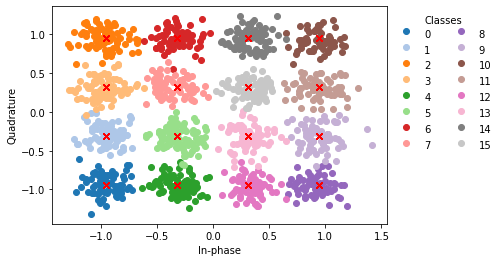

In [30]:
plot_symbols(X_train, y_train, symbs, QAM_modulation=M)

## Classifiers

### Random Forest

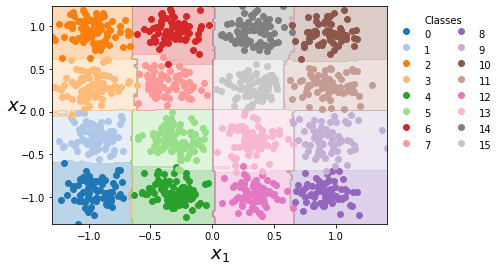

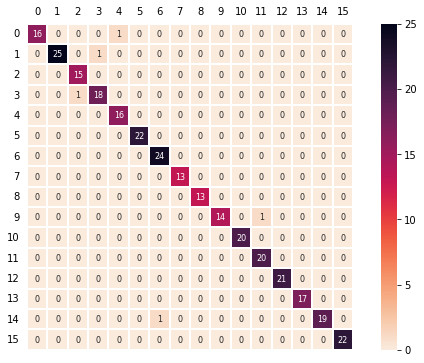

<module 'matplotlib.pyplot' from '/home/lucas/inteligencia_computacional/lib/python3.8/site-packages/matplotlib/pyplot.py'>

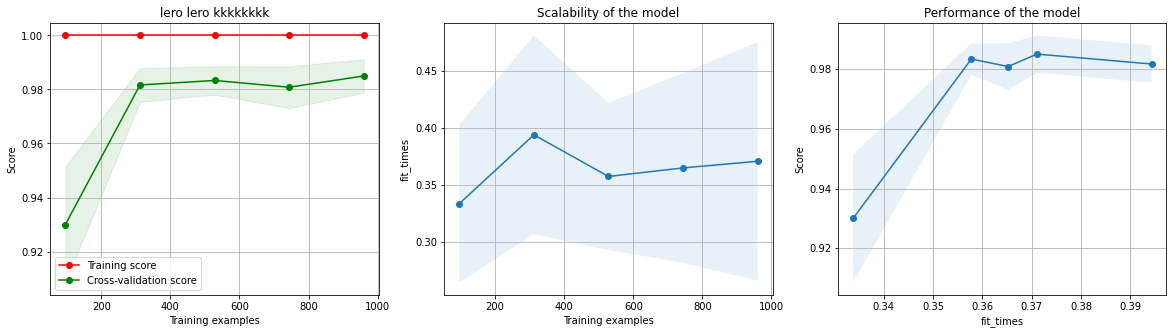

In [31]:
clf_RF = RandomForestClassifier(max_depth=50, n_estimators=50, n_jobs=-1).fit(X_train, y_train)
plot_decision_boundary(clf_RF, X_train, y_train, legend=True)
plot_confusion_matrix(clf_RF, X_test, y_test, M)
plot_learning_curve(estimator=clf_RF,title="lero lero kkkkkkkk", X=X_train, y=y_train, n_jobs=-1)

In [32]:
clf_RF_ser = ser(clf_RF, X_test, y_test)
print(f'Random Forest:\n SER:\t {clf_RF_ser:.2%}')

Random Forest:
 SER:	 1.67%


### K-nearest neighbors

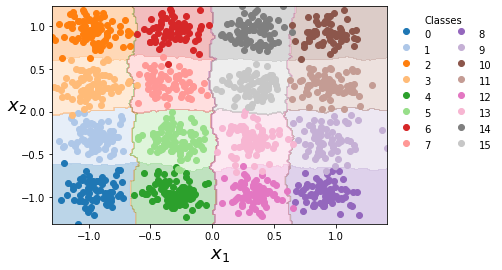

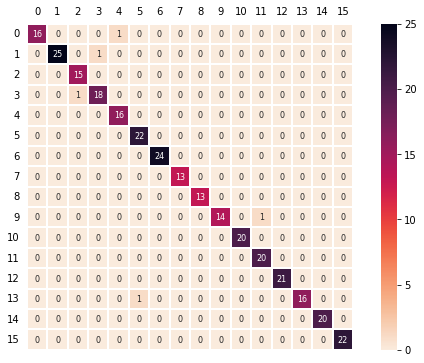

<module 'matplotlib.pyplot' from '/home/lucas/inteligencia_computacional/lib/python3.8/site-packages/matplotlib/pyplot.py'>

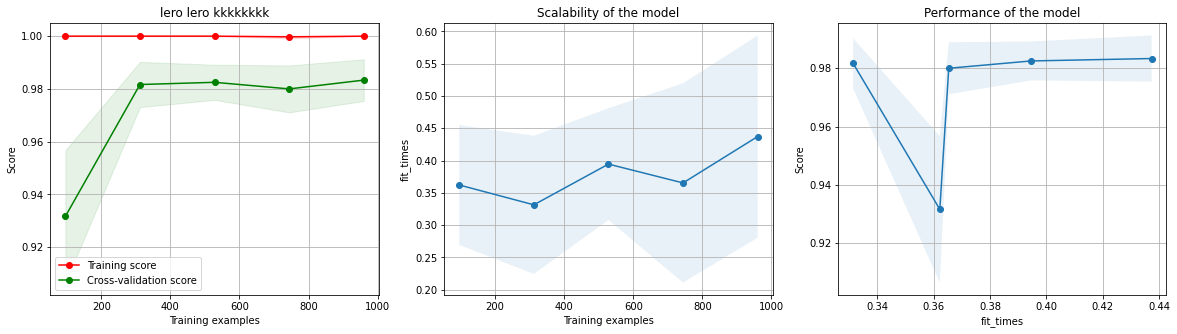

In [33]:
clf_KNN = KNeighborsClassifier(n_neighbors=11, n_jobs=-1).fit(X_train, y_train)
plot_decision_boundary(clf_KNN, X_train, y_train, legend=True)
plot_confusion_matrix(clf_KNN, X_test, y_test, M)
plot_learning_curve(estimator=clf_RF,title="lero lero kkkkkkkk", X=X_train, y=y_train, n_jobs=-1)

In [34]:
clf_KNN_ser = ser(clf_KNN, X_test, y_test)
print(f'K-nearest neighbors:\n SER:\t {clf_KNN_ser:.2%}')

K-nearest neighbors:
 SER:	 1.67%
